In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import semopy
import pandas as pd

import os
from utils import *

In [68]:
HOME = os.getcwd()
DATA = os.path.join(HOME, '..', 'data')
calib_mode = 'hats'

df = load_data(DATA, calib_mode, normalize=False, compute_iso=True)
df = df.rename({'isopl': 'isoPl', 'isoev': 'isoEv'}, axis=1)

from sklearn.decomposition import PCA

# dfx = df.groupby('stimulus_id').mean()    
    

dfx = df.groupby('stimulus_id').mean() 
pca = PCA()
pc = pca.fit_transform(dfx[PAQ])

for i in range(8):
    dfx[f'pc{i+1}'] = pc[:, i]

pc = pca.transform(df[PAQ])
for i in range(8):
    df[f'pc{i+1}'] = pc[:, i]


In [4]:
df

,stimulus_id,chk,t,pid,pl,ch,vi,un,ca,an,ev,mo,isoPl,isoEv
0,1,1,51.751,1,60,72,63,6,40,31,85,41,0.090833,0.485391
1,1,1,79.917,2,80,50,80,0,0,0,100,0,0.419239,0.794975
2,1,1,65.831,3,70,60,60,40,50,40,60,50,0.124264,0.141421
3,1,1,51.471,4,89,9,89,8,55,21,63,21,0.615563,0.292254
4,1,1,51.135,5,66,66,64,40,31,60,64,13,0.071716,0.351299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,27,1,80.202,22,25,60,83,69,29,74,26,66,-0.243970,-0.037523
671,27,1,64.690,23,75,40,75,40,60,35,60,50,0.297487,0.097487
672,27,1,75.361,24,43,72,61,70,24,72,41,73,-0.295858,-0.014680
673,27,1,100.610,25,50,60,70,40,40,40,60,40,0.070711,0.229289


In [5]:
adjacency = pd.DataFrame(np.eye(8), columns=PAQ_CCW, index=PAQ_CCW)

for i, p in enumerate(PAQ_CCW):
    for j, q in enumerate(PAQ_CCW):
        if np.abs(i - j) in [1, 7]:
            adjacency.loc[p, q] = cos45
        if np.abs(i - j) in [3, 5]:
            adjacency.loc[p, q] = -cos45
        if np.abs(i - j) == 4:
            adjacency.loc[p, q] = -1
            
adjacency

,pl,vi,ev,ch,an,mo,un,ca
pl,1.000000,0.707107,0.000000,-0.707107,-1.000000,-0.707107,0.000000,0.707107
vi,0.707107,1.000000,0.707107,0.000000,-0.707107,-1.000000,-0.707107,0.000000
ev,0.000000,0.707107,1.000000,0.707107,0.000000,-0.707107,-1.000000,-0.707107
ch,-0.707107,0.000000,0.707107,1.000000,0.707107,0.000000,-0.707107,-1.000000
an,-1.000000,-0.707107,0.000000,0.707107,1.000000,0.707107,0.000000,-0.707107
mo,-0.707107,-1.000000,-0.707107,0.000000,0.707107,1.000000,0.707107,0.000000
un,0.000000,-0.707107,-1.000000,-0.707107,0.000000,0.707107,1.000000,0.707107
ca,0.707107,0.000000,-0.707107,-1.000000,-0.707107,0.000000,0.707107,1.000000


In [6]:
semopy.efa.explore_cfa_model(df)

'eta2 =~ pl + mo + an + ca + vi + ch + un + ev\n'

pl ~~ pl
pl ~~ vi
pl ~~ ev
pl ~~ ch
pl ~~ an
pl ~~ mo
pl ~~ un
pl ~~ ca
vi ~~ vi
vi ~~ ev
vi ~~ ch
vi ~~ an
vi ~~ mo
vi ~~ un
vi ~~ ca
ev ~~ ev
ev ~~ ch
ev ~~ an
ev ~~ mo
ev ~~ un
ev ~~ ca
ch ~~ ch
ch ~~ an
ch ~~ mo
ch ~~ un
ch ~~ ca
an ~~ an
an ~~ mo
an ~~ un
an ~~ ca
mo ~~ mo
mo ~~ un
mo ~~ ca
un ~~ un
un ~~ ca
ca ~~ ca
latentPl =~ 1.0 * pl + vi + ch + an + mo + ca
latentEv =~ vi + 1.0 * ev + ch + mo + un + ca
latentPl ~~ latentEv



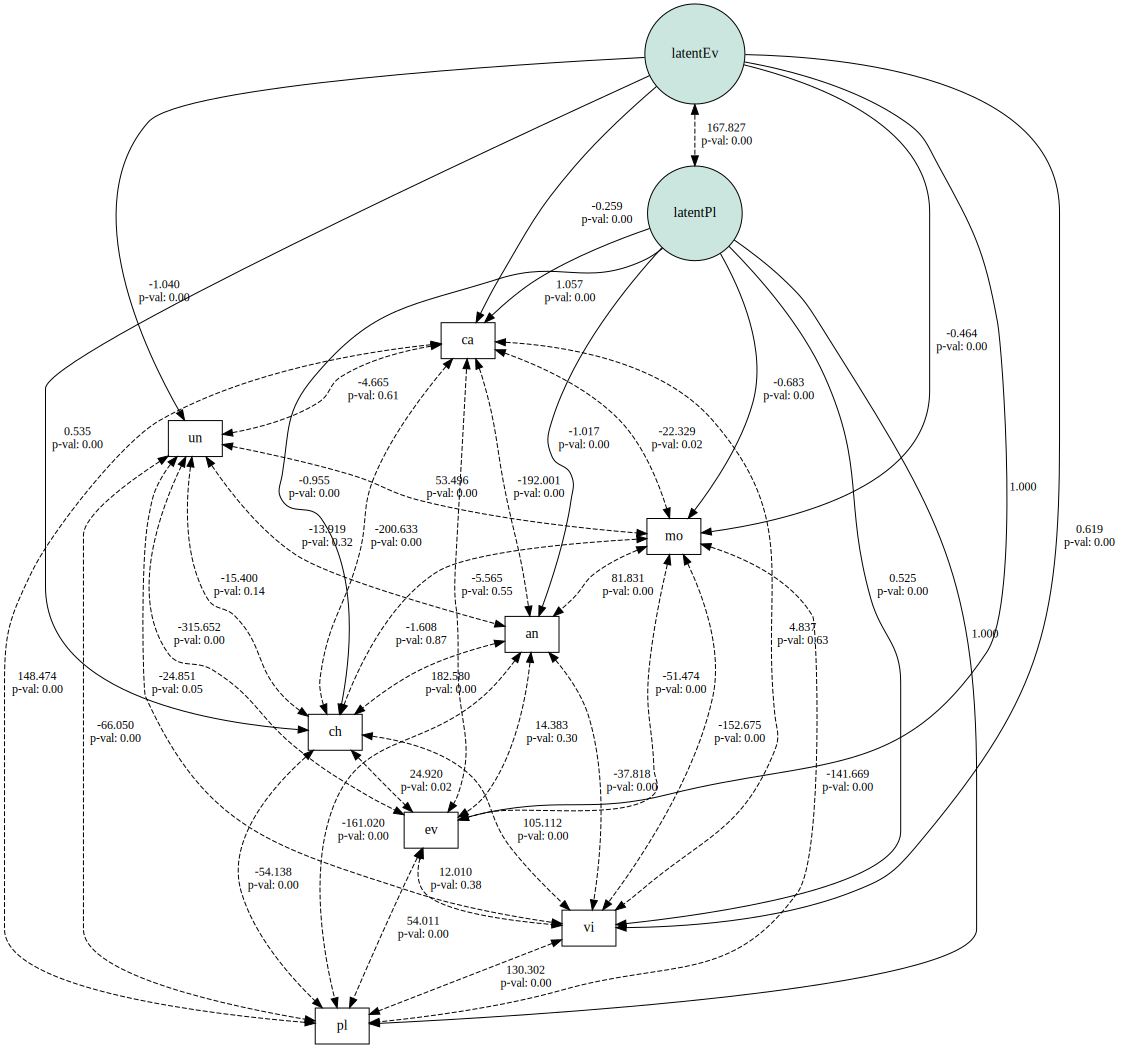

In [99]:
def make_simple_2d_model():
    model = ""
    for i, p in enumerate(PAQ_CCW):
        for q in PAQ_CCW[i:]:
        # model += f"DEFINE(ordinal) {p}\n"
            model += f"{p} ~~ {q}\n"
            # break
    
    for q in ['pl', 'ev']:
        factors = []
        for p in PAQ_CCW:
            if adjacency.loc[p, q] != 0:
                factors.append(f"1.0 * {p}" if p == q else p)
        factors = " + ".join(factors)
        model += f"latent{q.capitalize()} =~ {factors}\n"
    model += "latentPl ~~ latentEv\n"
    
    print(model)
    
    model = semopy.Model(model, mimic_lavaan=True)
    return model

m = make_simple_2d_model()
m.fit(df, clean_slate=True)
g = semopy.semplot(m, "pd.png", plot_covs=True)
g

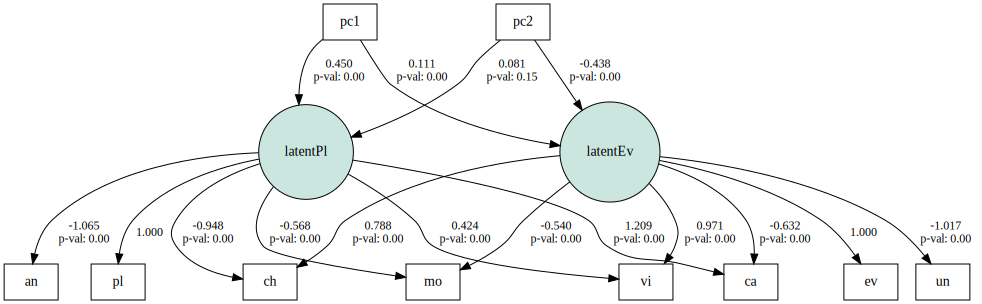

In [105]:
model = ""

for p in PAQ_CCW:
    model += f"{p} ~~ {p}\n"
    # model += f"DEFINE(ordinal) {p}\n"
    
    for q in PAQ_CCW:
        if adjacency.loc[p, q] != 0:
            model += f"{p} ~~ {q}\n"

for p in ['pl', 'ev']:
    latentP = f"latent{p.capitalize()}"
    model += f"{latentP} ~ pc1 + pc2\n"
    loadings = []
    for q in PAQ_CCW:
        if adjacency.loc[p, q] != 0:
            loadings += [f"1.0 * {q}"] if p == q else [f"{q}"]
        
            
    loadings = "+".join(loadings)
    
    model += f"{latentP} =~ {loadings} \n"
    
    model += f"latentPl ~~ latentEv\n"

    
    

m = semopy.Model(model)

m.fit(dfx, clean_slate=True)

g = semopy.semplot(m, "pd.png")# plot_covs=True)
g

In [80]:
m.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,latentPl,~,pc1,0.337076,0.175212,1.92382,0.054377
1,latentPl,~,pc2,0.001936,0.174998,0.011061,0.991175
2,latentEv,~,pc1,0.105393,0.167908,0.627685,0.53021
3,latentEv,~,pc2,-0.403580,0.168833,-2.39041,0.01683
4,pl,~,latentPl,1.000000,-,-,-
5,vi,~,latentPl,0.556561,0.076349,7.289645,0.0
6,vi,~,latentEv,0.682399,0.079913,8.539236,0.0
7,ch,~,latentPl,-0.989439,0.061234,-16.158384,0.0
8,ch,~,latentEv,0.674282,0.058094,11.606744,0.0
9,an,~,latentPl,-0.981854,0.0845,-11.61962,0.0
